## makemore - MLP v2, closer look

This implementation includes:
- Uniform initial loss 
- Multiple layers
- Diagnostics and visualizations
- BatchNorm

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np

names = open('data/names.txt', 'r').read().splitlines()
print("Sample names: ", names[5:12])
print("Number of names: ", len(names))

# create char to index mapping for set (vocabulary) of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print("Character mapping: ", itos)
print("Vocab Size: ", vocab_size)

Sample names:  ['charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily']
Number of names:  32033
Character mapping:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size:  27


In [23]:
# building dataset
context_length = 3 

def build_dataset(names):
    X, Y = [], []
    for name in names:

        context = [0] * context_length 
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(1337)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtrain, Ytrain = build_dataset(names[:n1])  # 80%
Xval, Yval = build_dataset(names[n1:n2])    # 10%
Xtest, Ytest = build_dataset(names[n2:])    # 10%

torch.Size([182594, 3]) torch.Size([182594])
torch.Size([22690, 3]) torch.Size([22690])
torch.Size([22864, 3]) torch.Size([22864])


In [24]:
# constructing network 

dim_embed = 10
hidden_layer_size = 200

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
# hidden layer
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) * (5/3) / (np.sqrt(dim_embed * context_length)) #* 0.2 
b1 = torch.randn(hidden_layer_size,                                 generator=g) * 0.02 # non-zero for entropy
# output layer
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g) * 0.01 # initialize small but not 0, so that symmetry is broken
b2 = torch.randn(vocab_size,                                        generator=g) * 0 # initialize with zeros; between this and above, gives near uniform initial probabilities

parameters = [C, W1, b1, W2, b2] # all parameters of the model
print(sum(p.nelement() for p in parameters)) # number of parameters in the model
for p in parameters:
    p.requires_grad = True

11897


In [25]:
# kaiming init
# std = gain / sqrt(fan_in) for tanh 
(5/3) / (np.sqrt(dim_embed * context_length)) # fan_in is 30; 10 dimensions * 3 characters

# gets to ~ the same validation loss, but no random numbers in weights initialization

np.float64(0.3042903097250923)

In [26]:
# training loop

def train(steps, lr, batch_size=32):
    batch_losses = []  # added here to capture loss later when we scale up neuron count
    for _ in range(steps):

        # batch
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
        Xb, Yb = Xtrain[ix], Ytrain[ix]

        # forward pass 
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = embcat @ W1 + b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        with torch.no_grad(): # no graph tracking for the update step
            for p in parameters:
                p.add_(p.grad, alpha=-lr)  # in-place, safe under no_grad

        batch_losses.append(loss.item())
    return batch_losses # added return here to capture loss later when we scale up neuron count

    # print(loss.item()) # loss per batch 

# whole-dataset evaluation helper (old)
@torch.no_grad() # decorator that disables gradient tracking
def evaluate(X, Y):
    emb = C[X] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    return loss.item()

# split evaluation helper (new)
@torch.no_grad() # decorator that disables gradient tracking
def split_evaluate(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    return loss.item()


In [27]:
# training

# track training loss
train_loss = []     # per epoch now
val_loss = []       # per epoch

# training parameters
epochs = 200
steps_per_epoch = 1000
learning_rate = 0.1

for epoch in range (epochs): 
    if epoch == 80: learning_rate = 0.04 # hacky learning rate decay
    if epoch == 150: learning_rate = 0.01 # hacky learning rate decay

    train(steps_per_epoch, learning_rate, batch_size=32) 
    train_loss.append(split_evaluate('train')) # capture train loss at epoch end rather than mini-batch loss
    val_loss.append(split_evaluate('val'))

    if epoch % 20 == 0: print(f"Epoch {epoch}: val loss {val_loss[-1]}")

Epoch 0: val loss 2.4657886028289795
Epoch 20: val loss 2.2497339248657227
Epoch 40: val loss 2.2328832149505615
Epoch 60: val loss 2.221571683883667
Epoch 80: val loss 2.1537482738494873
Epoch 100: val loss 2.145522117614746
Epoch 120: val loss 2.1569154262542725
Epoch 140: val loss 2.1484854221343994
Epoch 160: val loss 2.124727725982666
Epoch 180: val loss 2.1263275146484375


=== Loss summary ===
Train — last: 2.0335  (epoch 200)
Train —  min:  2.0335  (epoch 199)
Val   — last: 2.1223     (epoch 200)
Val   —  min:  2.1212     (epoch 175)


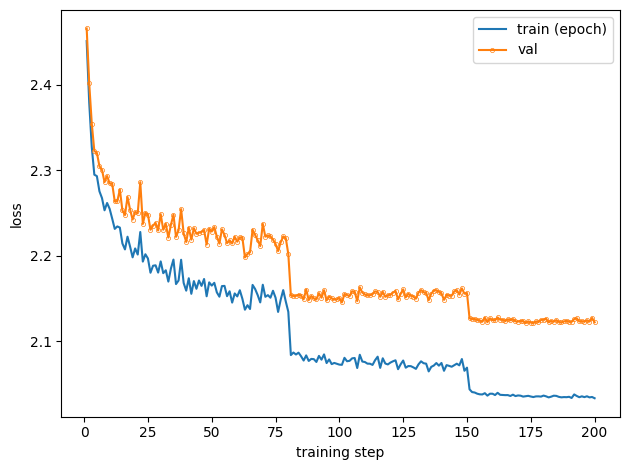

In [28]:
# showing training results

# optimizations:
#    initial loss is closer to final after initializing w2 and b2 to small values
#    small values rather than 0, to add entropy and prevent dead neurons/tanh saturation
#    kaiming init: mathematical approach to setting those small entropy values

E = len (train_loss)      # number of epochs
xs = np.arange(1, E+1)


# --- plot (epoch-level curves) ---
plt.figure()
plt.plot(xs, train_loss, label='train (epoch)')
plt.plot(xs, val_loss, marker='o', ms=3, mew=0.5, mfc='none', mec='auto', label='val')
plt.xlabel('training step'); plt.ylabel('loss'); plt.legend(); plt.tight_layout()


ti = int(np.argmin(train_loss))   # index of min train loss (epoch-level)
vi = int(np.argmin(val_loss))     # index of min val loss (epoch-level)

print("=== Loss summary ===")
print(f"Train — last: {train_loss[-1]:.4f}  (epoch {E})")
print(f"Train —  min:  {train_loss[ti]:.4f}  (epoch {ti})")

print(f"Val   — last: {val_loss[-1]:.4f}     (epoch {E})")
print(f"Val   —  min:  {val_loss[vi]:.4f}     (epoch {vi})")


In [29]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * context_length # initializes with all '.' chars 
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample
      context = context[1:] + [ix] # slide window
      out.append(ix)
      if ix == 0: # break on end token '.'
        break
    
    print(''.join(itos[i] for i in out))

one.
deavaevynn.
camela.
aili.
amaleydesha.
jenardie.
abihrytavidiel.
daklar.
theya.
aniyari.
brantarrottalynn.
emyan.
sayconte.
siant.
yuhuab.
dai.
reddylleny.
royalani.
colia.
ela.


### Optimizations

#### Expected loss at initialization

In [67]:
-torch.tensor(1/vocab_size).log().item() # expected loss of uniform distribution (each char equally likely to be next)

# set b2 and W2 lower to get near uniform initial probabilities on logits -> achieve near expected loss at initialization

3.295836925506592

#### Saturated tanh at initialization

h shape:  torch.Size([32, 200])


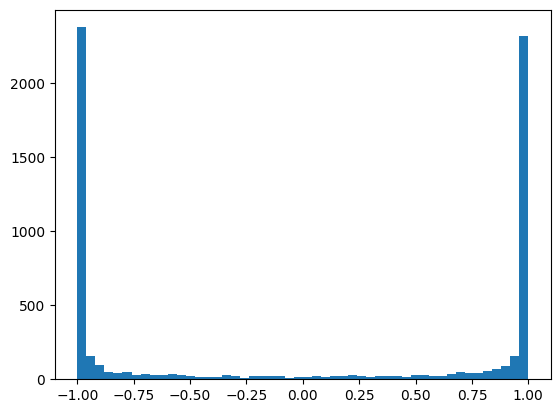

In [ ]:
# recreate h for inspection

dim_embed = 10
hidden_layer_size = 200
context_length = 3

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) 
b1 = torch.randn(hidden_layer_size,                                 generator=g)
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g) * 0.01 # initialize small but not 0, so that symmetry is broken
b2 = torch.randn(vocab_size,                                        generator=g) * 0 # initialize with zeros; between this and above, gives near uniform initial probabilities

parameters = [C, W1, b1, W2, b2] # all parameters of the model
for p in parameters:
    p.requires_grad = True

for _ in range(200000):

    # batch
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass 
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    
    lr = 0.1 if _ < 100000 else 0.01

    # update
    with torch.no_grad():
        for p in parameters:
            p.add_(p.grad, alpha=-lr) 

    break # break after first step to inspect h

# h histogram
print("h shape: ", h.shape)

plt.hist(h.view(-1).tolist(), 50); # see h as a single vector -> list, plot values in histogram

# most values ate -1 or 1, so tanh is saturated for most neurons

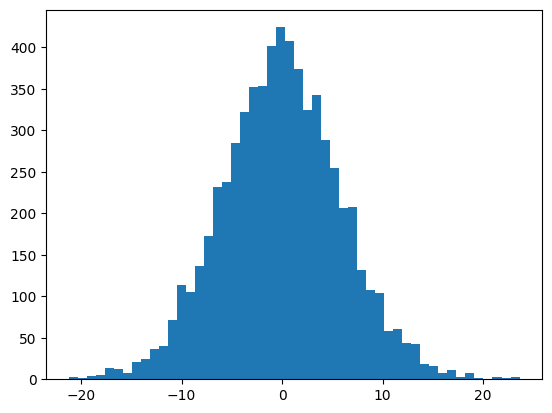

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # distribution of pre-activations

# with broad distribution of pre-activations, tanh will saturate for most neurons (as tanh squashes large inputs to -1 or 1)
# outputs of tanh close to -1 or 1 kills the gradients, so learning is very slow 
# backward pass for tanh: self.grad += (1 - t**2) * out.grad) ; high t -> low gradient (vanishing gradients)

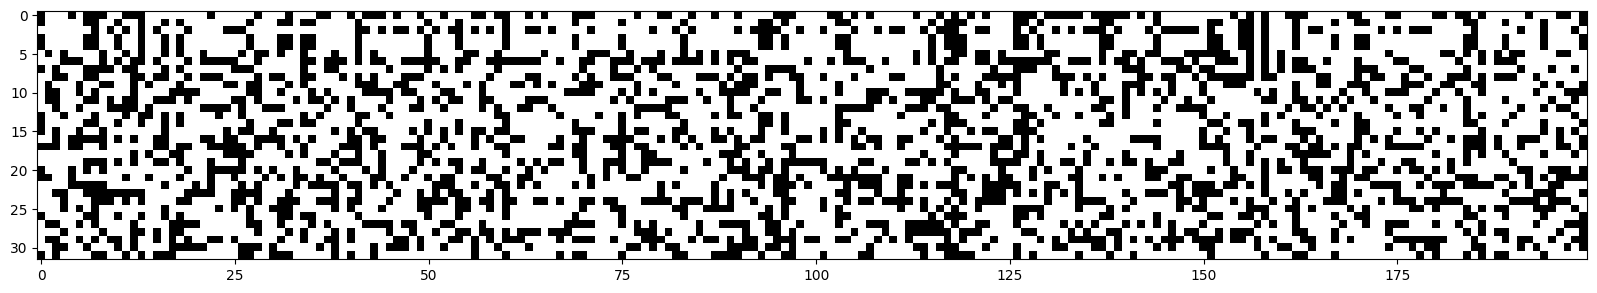

In [ ]:
# plot the neurons in h where the activation is saturated (abs value > 0.99); the white examples below

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# many are white, and backward gradient is limited at that layer  
# with a column entirely white, a neuron is "dead" and will never recover

# sigmoid, relu, etc. can all have dead neurons too
# leaky relu less likely; flat parts (low gradients) in activation functions can result in this

# mitigate in our model by squashing hpreact (low multiplier to W1 and b1)

h shape:  torch.Size([32, 200])


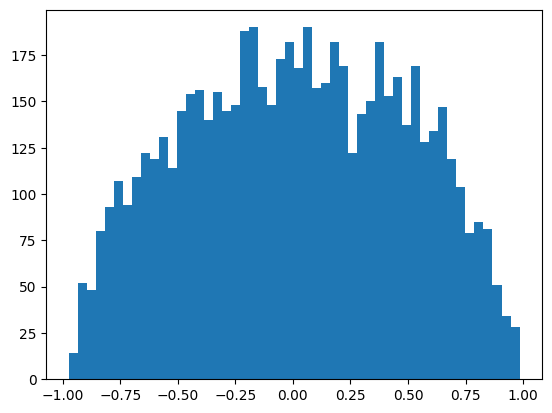

In [57]:
# recreate h for inspection

dim_embed = 10
hidden_layer_size = 200
context_length = 3

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) * 0.1
b1 = torch.randn(hidden_layer_size,                                 generator=g) * 0.01 # non-zero for entropy
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g) * 0.01 # initialize small but not 0, so that symmetry is broken
b2 = torch.randn(vocab_size,                                        generator=g) * 0 # initialize with zeros; between this and above, gives near uniform initial probabilities

parameters = [C, W1, b1, W2, b2] # all parameters of the model
for p in parameters:
    p.requires_grad = True

for _ in range(200000):

    # batch
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass 
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    
    lr = 0.1 if _ < 100000 else 0.01

    # update
    with torch.no_grad():
        for p in parameters:
            p.add_(p.grad, alpha=-lr) 

    break # break after first step to inspect h

# h histogram
print("h shape: ", h.shape)

plt.hist(h.view(-1).tolist(), 50); # see h as a single vector -> list, plot values in histogram

# histogram shows most values are now between -1 and 1, so tanh is not saturated for most

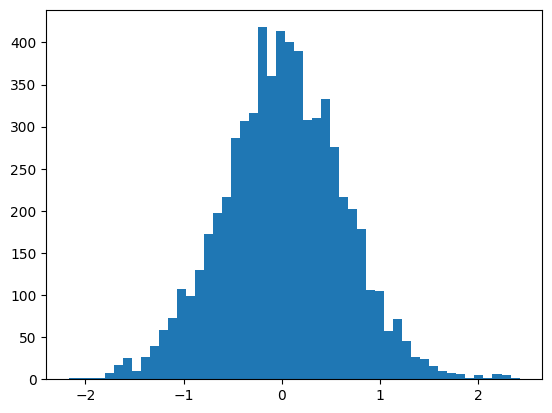

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50); # distribution of pre-activations is now smaller


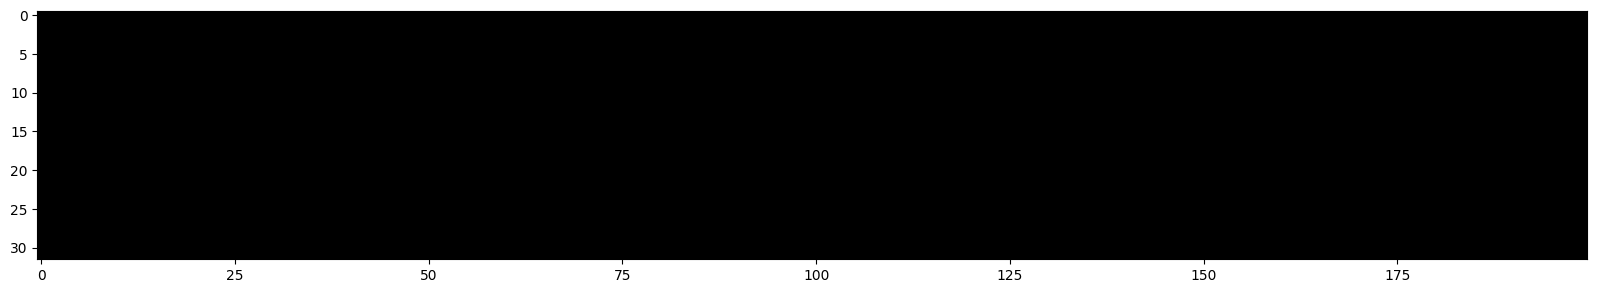

In [60]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # completely black columns: no gradients disappearing

### Kaiming initialization

Because nobody sets initialization for every layers' weights and biases scales by hand when the network gets deeper

tensor(-0.0229) tensor(0.9934)
tensor(-0.1092) tensor(1.8387)


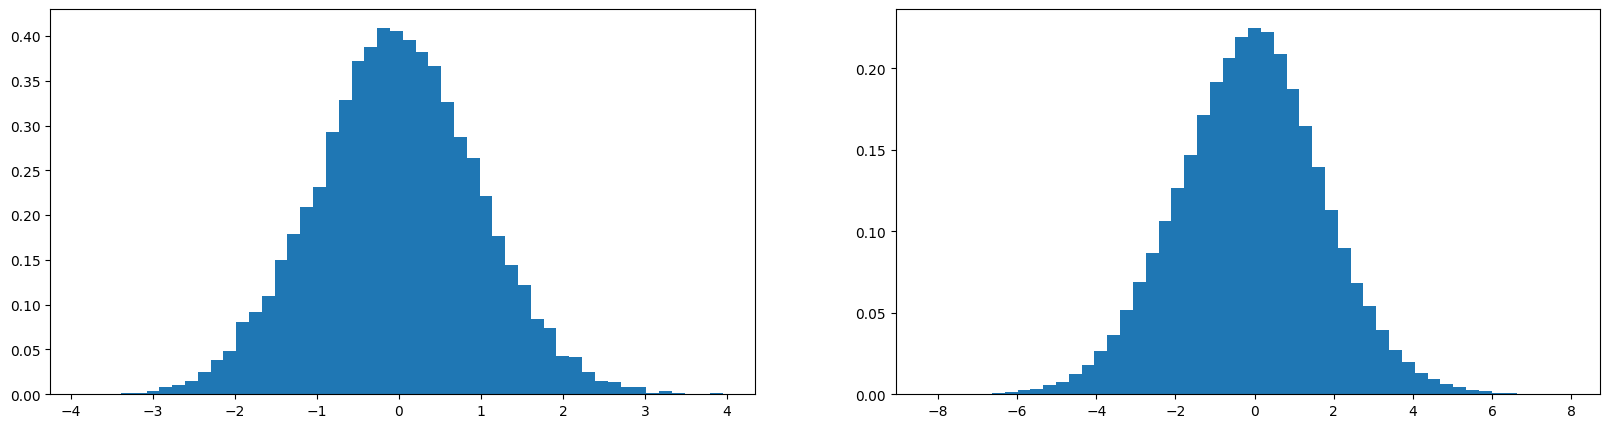

In [ ]:
# variance grows through layers

x = torch.randn(1000, 10)
w = torch.rand(10, 200) # *5 scale up demonstrates the problem
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# demonstrates that the variance of y is larger than that of x due to the matrix multiplication with w
# the standard deviation grows; the Gaussian distribution is expanding outward
# this is undesirable; we want more uniform activations throughout the neural net 

tensor(0.0061) tensor(1.0034)
tensor(0.0178) tensor(0.9738)


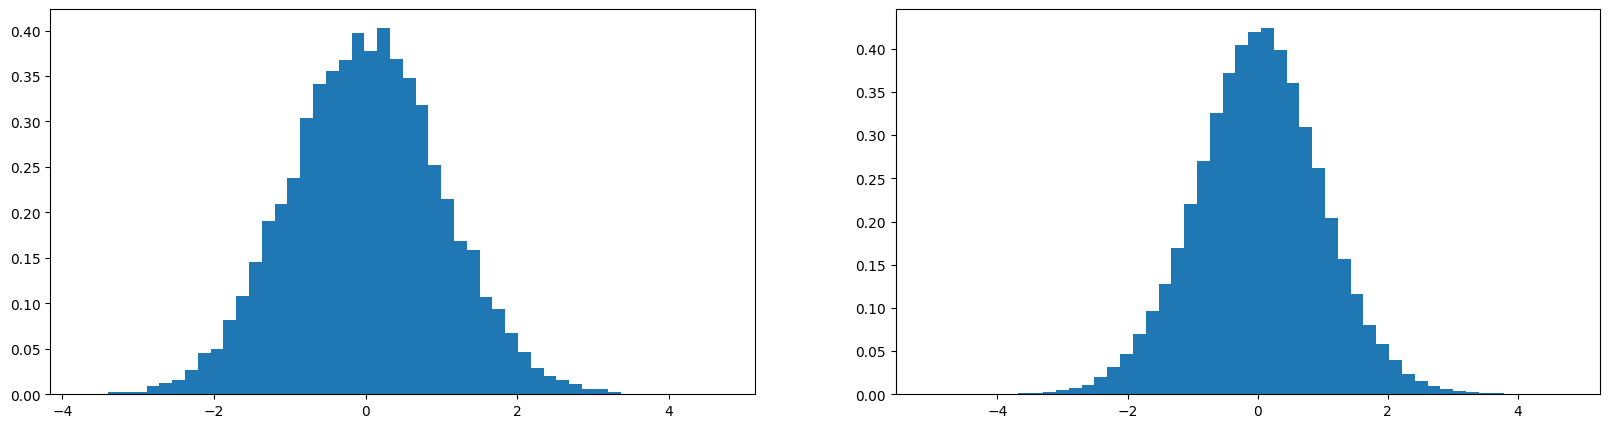

In [16]:
# calculating the init scale: kaiming init
# problem: matrix mult expands variance at each layer
# how do we initialize weights so that deep multilayer perceptrons have well-behaved activations through the layers?
# Kaiming He: https://arxiv.org/abs/1502.01852

x = torch.randn(1000, 10)
w = torch.rand(10, 200)*5 / (np.sqrt(10)*3)  # kaiming init scale: divide by sqrt of the fan-in (input size), multiply by gain factor
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# now the output Gaussian y has the same standard deviation of 1 as x

# this is: torch.nn.init.kaiming_normal_(tensor,a=0,mode='fan_in',nonlinearlity='leaky_relu') (different gains for different activation functions)

In [ ]:
# but this is still finicky and fragile
# modern practice: residual connections, batch or layer normalization, better optimizers like adam


tensor(0.1983)

#### 